<a href="https://colab.research.google.com/github/PKRaj007/PKRaj007/blob/main/PSO_OnePixelAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K
import matplotlib.pyplot as plt



In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

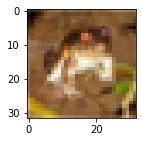

In [5]:
#x_train[0]
plt.figure(figsize=(15,2))
plt.imshow(x_train[0])

In [6]:
# 50000 samples and one dimentional array difing class
y_train.shape

(50000, 1)

In [7]:
y_train[:5] #first class 6 means-frog level(categories)

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

**Convert this 2d array into 1d array**

In [8]:
y_train=y_train.reshape(-1,) # we don't change 1st dimention 50000 so left it as -1 
#and instead of [6] we for convert it in 1d array left it blank.
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [9]:
x_test.shape

(10000, 32, 32, 3)

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
class_names[7]

'horse'

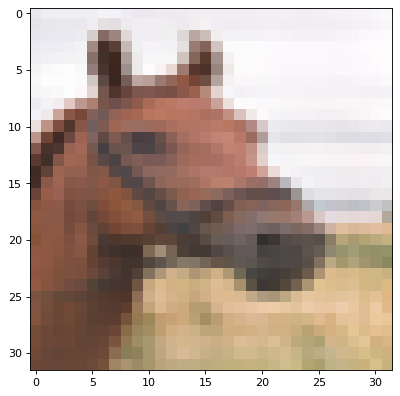

In [12]:
image_id = 99 # Image index in the test set
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(x_test[image_id]);

In [13]:
import helper

In [14]:
help(helper)

Help on package helper:

NAME
    helper

PACKAGE CONTENTS


FILE
    (built-in)




Perturbing Image

In [15]:
def perturb_image(xs, img):
  #xs perturbations [x,y,r,g,b]
    # If this function is passed just one perturbation vector (one pixel perturbation),
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    print(xs)
    # Repet this on image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x ( single pixel) into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        #split seprate array into its single elements (seperator,maxsplit);
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

**Design Model** 
- All Conv

In [16]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K

import keras
from keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from keras.layers.pooling import AvgPool2D
from google.colab.patches import cv2_imshow
from keras.layers import *
from keras import Input

In [17]:
def allConvModel(input, num_classes):
  input = Input(shape = (32,32,3))
  #changing filters from 64 -> 16
  layer_1 = Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu")(input)
  layer_2 = Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu")(layer_1)
  layer_3 = Conv2D(filters=96, kernel_size=(3,3), padding="same", strides=2, activation="relu")(layer_2)
  layer_4 = Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu")(layer_3)
  layer_5 = Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu")(layer_4)

  dropout_layer = Dropout(rate=0.3, seed=None)(layer_5)

  layer_6 = Conv2D(filters=192, kernel_size=(3,3), strides=2, padding="same", activation="relu")(dropout_layer)
  layer_7 = Conv2D(filters=192, kernel_size=(3,3), strides=2, padding="same", activation="relu")(layer_6)
  layer_8 = Conv2D(filters=192, kernel_size=(1,1), padding="same", activation="relu")(layer_7)
  layer_9 = Conv2D(filters=10, kernel_size=(1,1), padding="same", activation="relu")(layer_8)

  avg_pooling_layer = AveragePooling2D(pool_size=(4,4))(layer_9)
  flatten_layer = Flatten()(avg_pooling_layer)
  # flatten_layer = Dense(num_classes, activation = 'sigmoid')(avg_pooling_layer)
  activation_layer = Dense(num_classes, activation = 'sigmoid')(flatten_layer)
  
  allConvModel = Model(inputs=input,outputs=activation_layer)
  return allConvModel

input = Input(shape = (32,32,3))
allConv = allConvModel(input, 10)
allConv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        83040     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        83040     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 192)       166080    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 192)       331968    
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0     

**Train Model**

In [18]:
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.metrics as tfm

In [19]:
# opt = SGD(learning_rate=0.001)
#allConv.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])

In [20]:
allConv.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
# categorical_crossentropy use in case of one hot encode target values
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [22]:
allConv_results = allConv.fit(x_train, y_train, epochs=30, batch_size=64, verbose=1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 32s 25ms/step - loss: 2.3080 - accuracy: 0.0976
Epoch 2/30
782/782 [==============================] - 19s 24ms/step - loss: 2.3027 - accuracy: 0.0987
Epoch 3/30
782/782 [==============================] - 19s 25ms/step - loss: 2.3027 - accuracy: 0.0980
Epoch 4/30
782/782 [==============================] - 19s 25ms/step - loss: 2.3027 - accuracy: 0.0966
Epoch 5/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0988
Epoch 6/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0983
Epoch 7/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0964
Epoch 8/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0997
Epoch 9/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0987
Epoch 10/30
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accurac

In [23]:
#history = allConv.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1)

In [24]:
#loss_train = history.history['loss']
#loss_val =history.history['loss']
#epochs = range(1,5)
#plt.plot(epochs, loss_train, 'g', label='loss')
#plt.plot(epochs, loss_val, 'b', label='loss')
#plt.title('Training and Validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [25]:
_, acc = allConv.evaluate(x_test, y_test, verbose=0)
print(acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


0.10000000149011612


In [26]:
print(x_train.shape, y_test.shape, x_test.shape, y_train.shape)

(50000, 32, 32, 3) (10000, 1) (10000, 32, 32, 3) (50000,)


In [27]:
allConv.predict(x_test)
#y_pred=allConv.predict(x_test)

array([[0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ],
       [0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ],
       [0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ],
       ...,
       [0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ],
       [0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ],
       [0.4992901 , 0.5014433 , 0.49951088, ..., 0.5004976 , 0.49955896,
        0.4983464 ]], dtype=float32)

In [28]:
#y_class_names = [np.argmax(element) for element in y_pred]
#y_class_names[:5]

In [29]:
y_test[:5]

array([[3],
       [8],
       [8],
       [0],
       [6]], dtype=uint8)

In [31]:
#class_names[y_class_names[6]]

1 Pixel Attack

In [32]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 33.3 MB/s 


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [34]:
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmin
from numpy import min
from numpy import around
from matplotlib import pyplot
import pytest
import math


# python implementation of particle swarm optimization (PSO)
# minimizing rastrigin and sphere function
 
import random
import math    # cos() for Rastrigin
import copy    # array-copying convenience
import sys     # max float
 
 
#-------fitness functions---------
 
#sphere function
def fitness_sphere(position):
    fitnessVal = 0.0
    for i in range(len(position)):
        xi = position[i]
        fitnessVal += (xi*xi);
    return fitnessVal;
#-------------------------
 
#particle class
class Particle:
  def __init__(self, fitness, dim, minx, maxx, seed):
    self.rnd = random.Random(seed)
 
    # initialize position of the particle with 0.0 value
    self.position = [0.0 for i in range(dim)]
 
     # initialize velocity of the particle with 0.0 value
    self.velocity = [0.0 for i in range(dim)]
 
    # initialize best particle position of the particle with 0.0 value
    self.best_part_pos = [0.0 for i in range(dim)]
 
    # loop dim times to calculate random position and velocity
    # range of position and velocity is [minx, max]
    for i in range(dim):
      self.position[i] = ((maxx - minx) *
        self.rnd.random() + minx)
      self.velocity[i] = ((maxx - minx) *
        self.rnd.random() + minx)
 
    # compute fitness of particle
    self.fitness = fitness(self.position) # curr fitness
 
    # initialize best position and fitness of this particle
    self.best_part_pos = copy.copy(self.position)
    self.best_part_fitnessVal = self.fitness # best fitness
 
# particle swarm optimization function
def pso(fitness, max_iter, n, dim, minx, maxx):
  # hyper parameters
  w = 0.729    # inertia
  c1 = 1.49445 # cognitive (particle)
  c2 = 1.49445 # social (swarm)
 
  rnd = random.Random(0)
 
  # create n random particles
  swarm = [Particle(fitness, dim, minx, maxx, i) for i in range(n)]
 
  # compute the value of best_position and best_fitness in swarm
  best_swarm_pos = [0.0 for i in range(dim)]
  best_swarm_fitnessVal = sys.float_info.max # swarm best
 
  # computer best particle of swarm and it's fitness
  for i in range(n): # check each particle
    if swarm[i].fitness < best_swarm_fitnessVal:
      best_swarm_fitnessVal = swarm[i].fitness
      best_swarm_pos = copy.copy(swarm[i].position)
 
  # main loop of pso
  Iter = 0
  while Iter < max_iter:
     
    # after every 10 iterations
    # print iteration number and best fitness value so far
    if Iter % 10 == 0 and Iter > 1:
      print("Iter = " + str(Iter) + " best fitness = %.3f" % best_swarm_fitnessVal)
 
    for i in range(n): # process each particle
       
      # compute new velocity of curr particle
      for k in range(dim):
        r1 = rnd.random()    # randomizations
        r2 = rnd.random()
     
        swarm[i].velocity[k] = (
                                 (w * swarm[i].velocity[k]) +
                                 (c1 * r1 * (swarm[i].best_part_pos[k] - swarm[i].position[k])) + 
                                 (c2 * r2 * (best_swarm_pos[k] -swarm[i].position[k]))
                               ) 
 
 
        # if velocity[k] is not in [minx, max]
        # then clip it
        if swarm[i].velocity[k] < minx:
          swarm[i].velocity[k] = minx
        elif swarm[i].velocity[k] > maxx:
          swarm[i].velocity[k] = maxx
 
 
      # compute new position using new velocity
      for k in range(dim):
        swarm[i].position[k] += swarm[i].velocity[k]
   
      # compute fitness of new position
      swarm[i].fitness = fitness(swarm[i].position)
 
      # is new position a new best for the particle?
      if swarm[i].fitness < swarm[i].best_part_fitnessVal:
        swarm[i].best_part_fitnessVal = swarm[i].fitness
        swarm[i].best_part_pos = copy.copy(swarm[i].position)
 
      # is new position a new best overall?
      if swarm[i].fitness < best_swarm_fitnessVal:
        best_swarm_fitnessVal = swarm[i].fitness
        best_swarm_pos = copy.copy(swarm[i].position)
     
    # for-each particle
    Iter += 1
  #end_while
  return best_swarm_pos

In [35]:
# Driver code for Sphere function
print("\nBegin particle swarm optimization on sphere function\n")
dim = 3
fitness = fitness_sphere
 
 
print("Goal is to minimize sphere function in " + str(dim) + " variables")
print("Function has known min = 0.0 at (", end="")
for i in range(dim-1):
  print("0, ", end="")
print("0)")
 
num_particles = 50
max_iter = 100
 
print("Setting num_particles = " + str(num_particles))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting PSO algorithm\n")

best_position = pso(fitness, max_iter, num_particles, dim, -10.0, 10.0)
 
print("\nPSO completed\n")
print("\nBest solution found:")
print(["%.6f"%best_position[k] for k in range(dim)])
fitnessVal = fitness(best_position)
print("fitness of best solution = %.6f" % fitnessVal)
 
print("\nEnd particle swarm for sphere function\n")


Begin particle swarm optimization on sphere function

Goal is to minimize sphere function in 3 variables
Function has known min = 0.0 at (0, 0, 0)
Setting num_particles = 50
Setting max_iter    = 100

Starting PSO algorithm

Iter = 10 best fitness = 0.189
Iter = 20 best fitness = 0.012
Iter = 30 best fitness = 0.001
Iter = 40 best fitness = 0.000
Iter = 50 best fitness = 0.000
Iter = 60 best fitness = 0.000
Iter = 70 best fitness = 0.000
Iter = 80 best fitness = 0.000
Iter = 90 best fitness = 0.000

PSO completed


Best solution found:
['0.000004', '-0.000001', '0.000007']
fitness of best solution = 0.000000

End particle swarm for sphere function



In [36]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [37]:
cifar_model = models.vgg16(pretrained=True, init_weights=False)
cifar_model.classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
cifar_model = cifar_model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [38]:
BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [39]:
def test(epoch=None, is_validation=False):
    cifar_model.eval()
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = cifar_model(inputs)
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))

In [40]:
optimizer = optim.Adam(cifar_model.parameters())

# Training
def train(epoch):
    cifar_model.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
    test(epoch, is_validation=True)

In [41]:
TRAIN_EPOCHS = 20
WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")

if WEIGHTS_PATH.is_file():
    cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(cifar_model.state_dict(), WEIGHTS_PATH)

100%|██████████| 313/313 [00:26<00:00, 11.66it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 313/313 [00:26<00:00, 11.93it/s]


In [42]:
test()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy: 1000/10000


In [43]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

True Label: deer 4
Prediction: bird 2
Label Probabilities: tensor([0.0993, 0.0999, 0.1016, 0.0999, 0.1003, 0.0993, 0.1006, 0.1004, 0.0997,
        0.0991], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10033858567476273


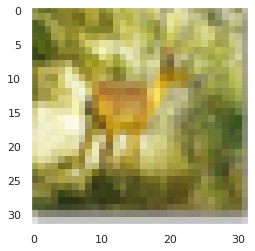

In [44]:
test_img, test_label = test_set[500]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, cifar_model)

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: deer 4
Prediction: bird 2
Label Probabilities: tensor([0.0993, 0.0999, 0.1016, 0.0999, 0.1003, 0.0993, 0.1006, 0.1004, 0.0997,
        0.0991], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10033858567476273


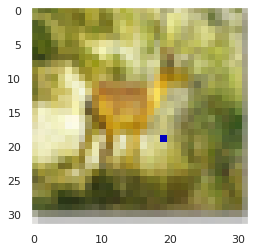

In [45]:
def perturb(p, img):
    # Elements of p(perturbation)[x,y,r,g,b] should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()  #image each pixcels
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb) # Changing color of xy pixel
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img) #pertubeted image
    print("Perturbation:", p) #p=[x,y,r,g,b]
    show(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, cifar_model)

Target Probability [Iteration 0]: 0.10033858567476273
Target Probability [Iteration 10]: 0.10033858567476273
Target Probability [Iteration 20]: 0.10033858567476273
Target Probability [Iteration 30]: 0.10033858567476273
Target Probability [Iteration 40]: 0.10033858567476273
Target Probability [Iteration 50]: 0.10033858567476273
Target Probability [Iteration 60]: 0.10033858567476273
Target Probability [Iteration 70]: 0.10033858567476273
Target Probability [Iteration 80]: 0.10033858567476273
Target Probability [Iteration 90]: 0.10033858567476273
Perturbation: [0.44901214 0.61727613 0.89595997 0.4109666  0.13958137]
True Label: deer 4
Prediction: bird 2
Label Probabilities: tensor([0.0993, 0.0999, 0.1016, 0.0999, 0.1003, 0.0993, 0.1006, 0.1004, 0.0997,
        0.0991], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10033858567476273


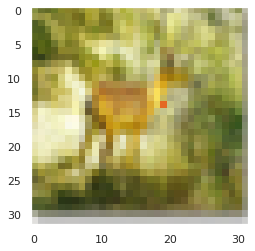

In [46]:
# Pertube and tells the probability
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img) #perturbated image by xs=[x,y,r,g,b]
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

# Generates Child and Return(Mutate)
def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5)) # take array of 400(pixel),5(xyrgb) and fill with [0,1)
    # means 400 diff perturbated images are found in each iteration(Generation)
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors] # Updte candidatea
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
_ = attack(cifar_model, test_img, test_label)

In [47]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(cifar_model, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

airplane 0 False 0.09933697432279587
automobile 1 False 0.09987429529428482
bird 2 False 0.10155139863491058
cat 3 False 0.09985096752643585
deer 4 True Label
dog 5 False 0.09926701337099075
frog 6 False 0.10055457055568695
horse 7 False 0.10042329877614975
ship 8 False 0.09966976940631866
truck 9 False 0.09913308918476105
